# Описание
Это ноутбук к первой контрольной точке.
В нем содержится код реализации алгоритма CEBC, описанного в статье. Работа с картой во многом наследована от наших лабораторных работ. Мы также использовали функцию prioritized_planning из лабораторной работы по многоагентному планированию, в качестве 'off-the-shelf CMAPF solver', описанного в оригинальной статье.  

In [1]:
from utils import Map, prioritized_planning, shortest_first, draw,simple_test, convert_string_to_cells, read_lists_from_file, manhattan_distance
from collections import deque
import numpy as np

### MAPFOU


In [2]:
class SearchNode:
    def __init__(self, i,j, is_possible_obstacle=False, is_sense=False):
        self.i = i
        self.j = j
        self.left = None
        self.right = None
        self.is_sense = is_sense


    def __repr__(self):
        if self.is_sense:
            return "sense"
        else:
            return f"SearchNode({self.i, self.j})"
def create_branch(pairs):
    if not pairs:
        return None
    root = SearchNode(pairs[0][0], pairs[0][1])
    current = root
    for i, j in pairs[1:]:
        new_node = SearchNode(i, j)
        current.right = new_node
        current = current.right
    return root
def AssumeObs(task_map, c, u):
    new_map=task_map
    for i in u:
        new_map._cells[i[0]][i[1]] = 0
    for i in c: 
        new_map._cells[i[0]][i[1]] = 1
    return new_map

## Псевдокод алгоритма
<img src='data/cebc_pseudocode.png' width=540, heigth=240>

In [3]:
def CEBC(graph, s, t, c, u):
    new_graph = AssumeObs(graph, c, u)
    plan = prioritized_planning(new_graph, s, t,20000, manhattan_distance, shortest_first)[1]
    branches = [create_branch(path) for path in plan]
    queue = deque(branches)
    new_starts = []
    previous_level_coords = [(k.i, k.j) for k in branches]
    while queue:
        next_level = deque()
        current_level_coords = []
        obstacle_found = False

        for node in queue:
            if node is not None:
                current_level_coords.append((node.i, node.j))
                if (node.i, node.j) in u:
                    obstacle_found = True
                    obstacle_coords = (node.i, node.j)
                if node.right:
                    next_level.append(node.right)

        if obstacle_found:
            new_starts = previous_level_coords
        previous_level_coords = current_level_coords
        queue = next_level
        if obstacle_found:
            new_u = u.copy()
            new_c = c.copy()
            new_u.remove(obstacle_coords)
            new_c.add(obstacle_coords)
            subtrees_set = CEBC(graph, new_starts,t,new_c,new_u)
            counter=0
            for n in branches:
                if (n.i, n.j) == (subtrees_set[counter].i, subtrees_set[counter].j):
                    buf = n.right
                    sense = SearchNode(n.i,n.j, is_sense=True)
                    n.right = sense
                    sense.right = buf
                    sense.left = subtrees_set[counter].right
                else:    
                    while n.right:
                        if (n.i, n.j) == (subtrees_set[counter].i, subtrees_set[counter].j):
                            buf = n.right
                            sense = SearchNode(n.i,n.j, is_sense=True)
                            n.right = sense
                            sense.right = buf
                            try:
                                sense.left = subtrees_set[counter].right
                            except:
                                sense.left = subtrees_set[counter]
                            break
                        else: 
                            n = n.right
                counter+=1
            u.remove(obstacle_coords)
    return branches

## Визуализация и тесты

Карту пока что задаём непосредственно в самой ячейке запуска, это позволяет упростить изучение различных сценариев. 

In [4]:
def print_tree(node=None, prefix="", children_prefix=""):
    if node is None:
        print('no root passed')
    node_repr = "sense" if node.is_sense else str((node.i, node.j))
    print(prefix + node_repr)
    if node.right:
        print_tree(node.right, children_prefix + "├── ", children_prefix + "│   ")
    if node.left:
        print_tree(node.left, children_prefix + "└── ", children_prefix + "    ")

In [5]:
map_str ='''
. . . . . 
. . P . . 
. # P . . 
. . . . .
. . P . .

'''

cells = convert_string_to_cells(map_str)
task_map = Map(cells)
all_starts = read_lists_from_file("data/mapf_st_starts.txt")
all_goals = read_lists_from_file("data/mapf_st_goals.txt")
u = set([tuple(pos) for pos in np.argwhere(task_map._cells == 2)])
c = set([tuple(pos) for pos in np.argwhere(task_map._cells == 1)])
starts = all_starts[0]
goals = all_goals[0]
trees = CEBC(task_map, starts, goals, set([]), u)

# Вывод структуры каждого дерева
for i, tree in enumerate(trees):
    print(f"Tree for agent {i+1}:")
    print_tree(tree)
    print()

Tree for agent 1:
(4, 4)
├── sense
│   ├── (3, 4)
│   │   ├── (3, 3)
│   │   │   ├── (2, 3)
│   │   │   │   ├── sense
│   │   │   │   │   ├── (2, 2)
│   │   │   │   │   │   ├── (1, 2)
│   │   │   │   │   │   │   ├── (1, 1)
│   │   │   │   │   └── (1, 3)
│   │   │   │   │       ├── (0, 3)
│   │   │   │   │       │   ├── (0, 2)
│   │   │   │   │       │   │   ├── (0, 1)
│   │   │   │   │       │   │   │   ├── (1, 1)
│   └── (4, 3)
│       ├── sense
│       │   ├── (4, 2)
│       │   │   ├── (4, 1)
│       │   │   │   ├── (3, 1)
│       │   │   │   │   ├── (3, 0)
│       │   │   │   │   │   ├── (2, 0)
│       │   │   │   │   │   │   ├── (1, 0)
│       │   │   │   │   │   │   │   ├── (1, 1)
│       │   └── (3, 3)
│       │       ├── (3, 2)
│       │       │   ├── (3, 1)
│       │       │   │   ├── (3, 0)
│       │       │   │   │   ├── (2, 0)
│       │       │   │   │   │   ├── (1, 0)
│       │       │   │   │   │   │   ├── (1, 1)

Tree for agent 2:
(1, 1)
├── sense
│   ├── (1, 2)
│   │   

## Драфт динамической визуализации

Примерно так планируется визуализировать пути агентов в динамике, однако на данный момент эта визуализация еще не готова

Path found! Steps: 26. Makespan: 6. Flowtime: 12. Correct: True


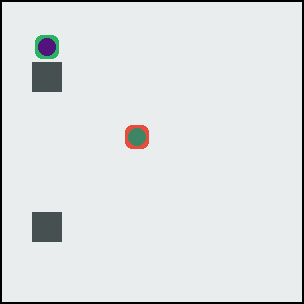

[[(4, 4), (3, 4), (2, 4), (1, 4), (1, 3), (1, 2), (1, 1)], [(1, 1), (1, 2), (1, 3), (2, 3), (3, 3), (3, 4), (4, 4)]]


In [6]:
simple_test(prioritized_planning, 0, 50000, manhattan_distance, shortest_first)